<a href="https://colab.research.google.com/github/avadhutc/Analytics/blob/prateek/Avadhut/Eva_Session_20_Assignment20_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential, Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
import cv2
from keras.layers import Activation


Using TensorFlow backend.


In [2]:
from keras.datasets import cifar100
(train_features, train_labels), (test_features, test_labels) = cifar100.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

169009152/169001437 [==============================] - 6s 0us/step


In [3]:
print(train_features.shape,train_labels.shape, test_features.shape, test_labels.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [4]:
print(np.mean(train_features[:,:,:,0]),np.mean(train_features[:,:,:,1]),np.mean(train_features[:,:,:,2]))
print(np.std(train_features[:,:,:,0]),np.std(train_features[:,:,:,1]),np.std(train_features[:,:,:,2]))

129.30416560546874 124.0699626953125 112.43405005859375
68.17024289920643 65.39180804385748 70.41837018804927


In [0]:
mean = [129.30, 124.07, 112.43]
std = [68.17, 65.39, 70.42]

In [6]:
train_features.max(),train_features.min(), test_features.max(),test_features.min()

(255, 0, 255, 0)

## Image Normalization

In [0]:
train_features = train_features.astype('float32')
test_features = test_features.astype('float32')

for i in range(3):
      train_features[:,:,:,i] = (train_features[:,:,:,i] - mean[i]) / std[i]
      test_features[:,:,:,i] = (test_features[:,:,:,i] - mean[i]) / std[i]

In [8]:
train_features.max(),train_features.min(), test_features.max(),test_features.min()

(2.0245671, -1.8973849, 2.0245671, -1.8973849)

In [0]:
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

#  Pretrained Imagenet ResNet34 Architecture for CIFAR 100 image size 32x32

In [13]:
!pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-aowxgplj
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-aowxgplj
  Running command git submodule update --init --recursive -q
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0b1-cp36-none-any.whl size=19977 sha256=da75678d50eb56b6158000bb98a1c76a60d858260d25606d88cd586e7705f3b6
  Stored in directory: /tmp/pip-ephem-wheel-cache-ez66o07l/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers


In [0]:
# for keras
from classification_models.keras import Classifiers


In [0]:

ResNet34, _ = Classifiers.get('resnet34')


In [0]:
base_model = ResNet34((224, 224, 3), weights='imagenet')

In [27]:
base_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_37 (ZeroPadding2 (None, 230, 230, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d_37[0][0]          
____________________________________________________________________________________________

## Pretrained Model Classifier Modification

In [21]:
base_model = ResNet34((32, 32, 3), weights='imagenet', include_top=False)
layer_19 = Convolution2D(100, 1, 1)(base_model.output)
globavgpool = GlobalAveragePooling2D()(layer_19)
out = Activation('softmax')(globavgpool)

model = Model(inputs=[base_model.input], outputs=[out])


85524480/85521592 [==============================] - 3s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(100, (1, 1))`
  


In [22]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_37 (ZeroPadding2 (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_37[0][0]          
____________________________________________________________________________________________

In [0]:
# import adam optimizer parameters
from keras.optimizers import Adam
# set adam optimizer parameters
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=390, epochs=100)`


Epoch 1/100
390/390 [==============================] - 99s 254ms/step - loss: 2.6544 - acc: 0.3275 - val_loss: 2.7668 - val_acc: 0.3196

Epoch 00001: val_acc improved from -inf to 0.31960, saving model to Imagenet_cifar100_weights_0_100.h5
Epoch 2/100
390/390 [==============================] - 87s 222ms/step - loss: 1.9376 - acc: 0.4733 - val_loss: 2.1830 - val_acc: 0.4269

Epoch 00002: val_acc improved from 0.31960 to 0.42690, saving model to Imagenet_cifar100_weights_0_100.h5
Epoch 3/100
390/390 [==============================] - 86s 220ms/step - loss: 1.7124 - acc: 0.5249 - val_loss: 2.0914 - val_acc: 0.4591

Epoch 00003: val_acc improved from 0.42690 to 0.45910, saving model to Imagenet_cifar100_weights_0_100.h5
Epoch 4/100
390/390 [==============================] - 86s 220ms/step - loss: 1.5542 - acc: 0.5653 - val_loss: 1.8722 - val_acc: 0.5054

Epoch 00004: val_acc improved from 0.45910 to 0.50540, saving model to Imagenet_cifar100_weights_0_100.h5
Epoch 5/100
390/390 [==========

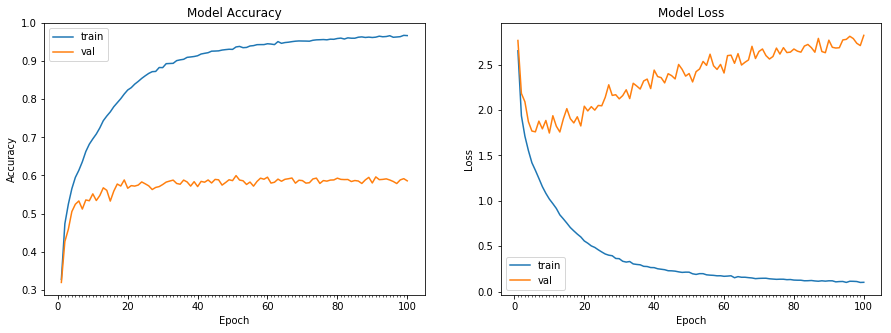

Accuracy on test data is: 58.60


In [24]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

final_weights_path = 'Imagenet_cifar100_weights_0_100.h5'

callbacks_list = [
    ModelCheckpoint(final_weights_path, monitor='val_acc', verbose = 1,save_best_only = True)
   
]

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=True,
                             # randomly shift images horizontally
                             width_shift_range=0.1,
                             # randomly shift images vertically
                             height_shift_range=0.1,
                             # set function that will be applied on each input
                             preprocessing_function=None,)

# Compile the model
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), callbacks = callbacks_list, verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

#  Pretrained Imagenet ResNet18 Architecture for CIFAR 100 image size 32x32

In [0]:

ResNet18, _ = Classifiers.get('resnet18')


In [0]:
base_model = ResNet18((224, 224, 3), weights='imagenet')

In [27]:
base_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_71 (ZeroPadding2 (None, 230, 230, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d_71[0][0]          
____________________________________________________________________________________________

## Pretrained Model Classifier Modification

In [29]:
base_model = ResNet18((32, 32, 3), weights='imagenet', include_top=False)
layer_19 = Convolution2D(100, 1, 1)(base_model.output)
globavgpool = GlobalAveragePooling2D()(layer_19)
out = Activation('softmax')(globavgpool)

model = Model(inputs=[base_model.input], outputs=[out])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(100, (1, 1))`
  


In [30]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_107 (ZeroPadding (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_107[0][0]         
____________________________________________________________________________________________

In [0]:
# import adam optimizer parameters
from keras.optimizers import Adam
# set adam optimizer parameters
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=390, epochs=100)`


Epoch 1/100
390/390 [==============================] - 56s 145ms/step - loss: 2.6183 - acc: 0.3363 - val_loss: 2.3944 - val_acc: 0.3864

Epoch 00001: val_acc improved from -inf to 0.38640, saving model to res18_Imagenet_cifar100_weights_0_100.h5
Epoch 2/100
390/390 [==============================] - 50s 128ms/step - loss: 1.9462 - acc: 0.4702 - val_loss: 2.1224 - val_acc: 0.4477

Epoch 00002: val_acc improved from 0.38640 to 0.44770, saving model to res18_Imagenet_cifar100_weights_0_100.h5
Epoch 3/100
390/390 [==============================] - 50s 128ms/step - loss: 1.7223 - acc: 0.5208 - val_loss: 2.2789 - val_acc: 0.4297

Epoch 00003: val_acc did not improve from 0.44770
Epoch 4/100
390/390 [==============================] - 50s 128ms/step - loss: 1.5951 - acc: 0.5534 - val_loss: 1.9607 - val_acc: 0.4838

Epoch 00004: val_acc improved from 0.44770 to 0.48380, saving model to res18_Imagenet_cifar100_weights_0_100.h5
Epoch 5/100
390/390 [==============================] - 50s 128ms/step

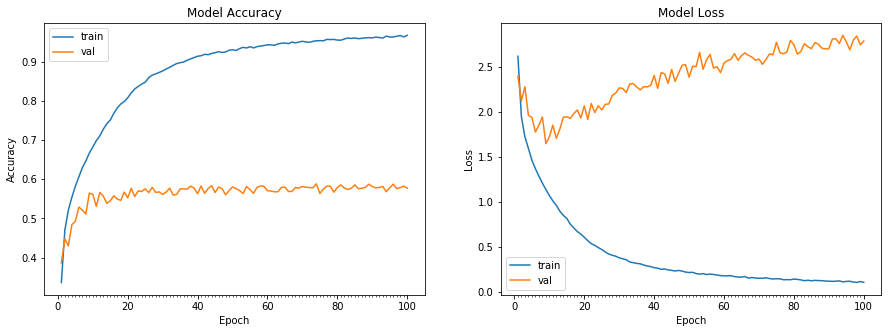

Accuracy on test data is: 57.66


In [32]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

final_weights_path = 'res18_Imagenet_cifar100_weights_0_100.h5'

callbacks_list = [
    ModelCheckpoint(final_weights_path, monitor='val_acc', verbose = 1,save_best_only = True)
   
]

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=True,
                             # randomly shift images horizontally
                             width_shift_range=0.1,
                             # randomly shift images vertically
                             height_shift_range=0.1,
                             # set function that will be applied on each input
                             preprocessing_function=None,)

# Compile the model
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), callbacks = callbacks_list, verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

#  Pretrained Modified Imagenet ResNet34 Architecture for CIFAR 100 image size 32x32

In [12]:
!pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-ikowt6rk
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-ikowt6rk
  Running command git submodule update --init --recursive -q
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0b1-cp36-none-any.whl size=19977 sha256=fcb9c6faabb416e14a47fc20dfa537f5f594a278829ebf0eefb24c180a6a5606
  Stored in directory: /tmp/pip-ephem-wheel-cache-5tr4yckr/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers


In [0]:
# for keras
from classification_models.keras import Classifiers


In [0]:

ResNet34, _ = Classifiers.get('resnet34')


In [15]:
base_model = ResNet34((224, 224, 3), weights='imagenet')








87580672/87578640 [==============================] - 3s 0us/step


In [16]:
base_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
____________________________________________________________________________________________

## Pretrained Model Classifier Modification

In [17]:
base_model = ResNet34((32, 32, 3), weights='imagenet', include_top=False)
layer_19 = Convolution2D(100, 1, 1)(base_model.output)
globavgpool = GlobalAveragePooling2D()(layer_19)
out = Activation('softmax')(globavgpool)

model = Model(inputs=[base_model.input], outputs=[out])


85524480/85521592 [==============================] - 3s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(100, (1, 1))`
  


In [18]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_35 (ZeroPadding2 (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_35[0][0]          
____________________________________________________________________________________________

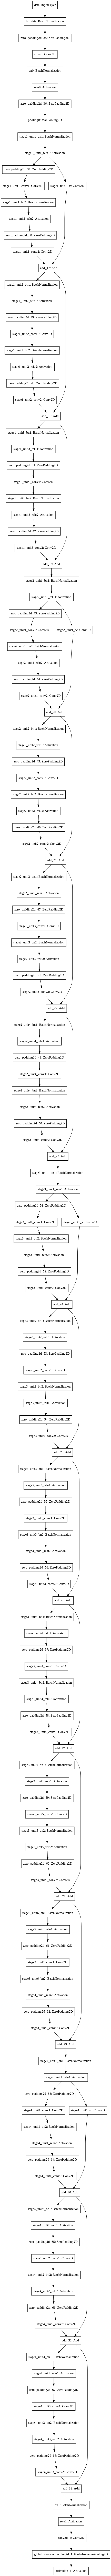

In [21]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [0]:
base_model = ResNet34((32, 32, 3), weights='imagenet', include_top=False)
layer_19 = Convolution2D(100, 1, 1)(base_model.output)
globavgpool = GlobalAveragePooling2D()(layer_19)
out = Activation('softmax')(globavgpool)

model = Model(inputs=[base_model.input], outputs=[out])

In [0]:
model_1 = Model(inputs=[base_model.input], outputs=[base_model.get_layer('add_23').output])

In [32]:
model_1.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_35 (ZeroPadding2 (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_35[0][0]          
____________________________________________________________________________________________

In [33]:
final_layer = Convolution2D(100, 1, 1)(model_1.output)
globavgpool = GlobalAveragePooling2D()(final_layer)
out = Activation('softmax')(globavgpool)

model_new = Model(inputs=[base_model.input], outputs=[out])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(100, (1, 1))`
  """Entry point for launching an IPython kernel.


In [34]:
model_new.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_35 (ZeroPadding2 (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_35[0][0]          
____________________________________________________________________________________________

In [0]:
# import adam optimizer parameters
from keras.optimizers import Adam
# set adam optimizer parameters
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=390, epochs=100)`


Epoch 1/100
390/390 [==============================] - 44s 114ms/step - loss: 2.6716 - acc: 0.3232 - val_loss: 2.6055 - val_acc: 0.3415

Epoch 00001: val_acc improved from -inf to 0.34150, saving model to Trimmed_Imagenet_cifar100_weights_0_100.h5
Epoch 2/100
390/390 [==============================] - 42s 109ms/step - loss: 1.9610 - acc: 0.4661 - val_loss: 2.2008 - val_acc: 0.4261

Epoch 00002: val_acc improved from 0.34150 to 0.42610, saving model to Trimmed_Imagenet_cifar100_weights_0_100.h5
Epoch 3/100
390/390 [==============================] - 31s 79ms/step - loss: 1.7357 - acc: 0.5179 - val_loss: 2.0529 - val_acc: 0.4627

Epoch 00003: val_acc improved from 0.42610 to 0.46270, saving model to Trimmed_Imagenet_cifar100_weights_0_100.h5
Epoch 4/100
390/390 [==============================] - 31s 79ms/step - loss: 1.5962 - acc: 0.5499 - val_loss: 1.8095 - val_acc: 0.5068

Epoch 00004: val_acc improved from 0.46270 to 0.50680, saving model to Trimmed_Imagenet_cifar100_weights_0_100.h5
E

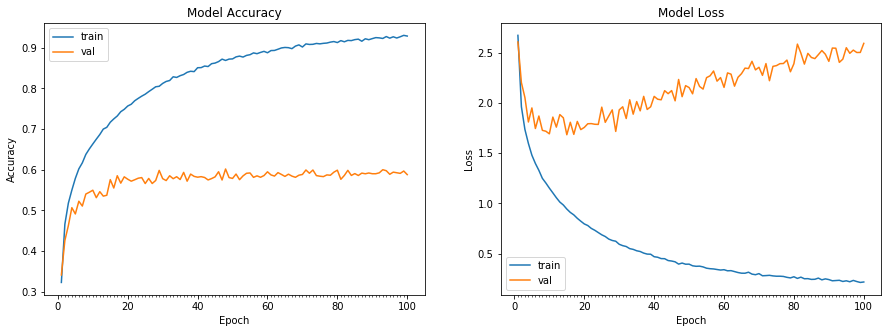

Accuracy on test data is: 1.37


In [36]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

final_weights_path = 'Trimmed_Imagenet_cifar100_weights_0_100.h5'

callbacks_list = [
    ModelCheckpoint(final_weights_path, monitor='val_acc', verbose = 1,save_best_only = True)
   
]

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=True,
                             # randomly shift images horizontally
                             width_shift_range=0.1,
                             # randomly shift images vertically
                             height_shift_range=0.1,
                             # set function that will be applied on each input
                             preprocessing_function=None,)

# Compile the model
model_new.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
start = time.time()
# Train the model
model_info = model_new.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), callbacks = callbacks_list, verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

#  Pretrained Imagenet ResNet18 Architecture for CIFAR 100 image size 128x128

In [0]:
import tensorflow as tf

In [0]:
from keras.datasets import cifar100
(train_features, train_labels), (test_features, test_labels) = cifar100.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

In [3]:
print(train_features.shape,train_labels.shape, test_features.shape, test_labels.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [0]:
train_features = train_features.astype('float32')
test_features = test_features.astype('float32')
train_features /= 255.0
test_features /= 255.0

In [5]:
print(np.mean(train_features[:,:,:,0]),np.mean(train_features[:,:,:,1]),np.mean(train_features[:,:,:,2]))
print(np.std(train_features[:,:,:,0]),np.std(train_features[:,:,:,1]),np.std(train_features[:,:,:,2]))

0.5070746 0.48654896 0.44091788
0.26733422 0.25643846 0.27615058


In [0]:
mean = [0.51, 0.481, 0.441]
std = [0.26, 0.25, 0.27]

In [7]:
train_features.max(),train_features.min(), test_features.max(),test_features.min()

(1.0, 0.0, 1.0, 0.0)

In [0]:
for i in range(3):
      train_features[:,:,:,i] = (train_features[:,:,:,i] - mean[i]) / std[i]
      test_features[:,:,:,i] = (test_features[:,:,:,i] - mean[i]) / std[i]

In [9]:
train_features.max(),train_features.min(), test_features.max(),test_features.min()

(2.076, -1.9615386, 2.076, -1.9615386)

In [0]:
def resize_dataset(images):
     resized_data = []
     for ind_ in range(images.shape[0]):
            resized_img = cv2.resize(images[ind_], (128, 128))
            resized_data.append(resized_img)
     resized_data = np.array(resized_data)
     return resized_data

In [0]:
train_features = resize_dataset(train_features)
test_features = resize_dataset(test_features)

In [12]:
print(train_features.shape,train_labels.shape, test_features.shape, test_labels.shape)

(50000, 128, 128, 3) (50000, 1) (10000, 128, 128, 3) (10000, 1)


In [0]:
#print(np.mean(train_features[:,:,:,0]),np.mean(train_features[:,:,:,1]),np.mean(train_features[:,:,:,2]))
#print(np.std(train_features[:,:,:,0]),np.std(train_features[:,:,:,1]),np.std(train_features[:,:,:,2]))

In [0]:
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [15]:
!pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-6dg4nby1
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-6dg4nby1
  Running command git submodule update --init --recursive -q
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0b1-cp36-none-any.whl size=19977 sha256=ed43a6c751879f21778f633e0a5cab23e90f6d1bb09eefd419946be47fe8df81
  Stored in directory: /tmp/pip-ephem-wheel-cache-mcnmfmcj/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers


In [0]:
# for keras
from classification_models.keras import Classifiers


In [0]:

ResNet18, _ = Classifiers.get('resnet18')


In [18]:
base_model = ResNet18((224, 224, 3), weights='imagenet')








46981120/46977688 [==============================] - 2s 0us/step


In [19]:
base_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
____________________________________________________________________________________________

## Pretrained Model Classifier Modification

In [20]:
base_model = ResNet18((128, 128, 3), weights='imagenet', include_top=False)
layer_19 = Convolution2D(100, 1, 1)(base_model.output)
globavgpool = GlobalAveragePooling2D()(layer_19)
out = Activation('softmax')(globavgpool)

model = Model(inputs=[base_model.input], outputs=[out])


A local file was found, but it seems to be incomplete or outdated because the md5 file hash does not match the original value of 318e3ac0cd98d51e917526c9f62f0b50 so we will re-download the data.
44924928/44920640 [==============================] - 2s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(100, (1, 1))`
  


In [21]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 128, 128, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_19 (ZeroPadding2 (None, 134, 134, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 64, 64, 64)   9408        zero_padding2d_19[0][0]          
____________________________________________________________________________________________

In [0]:
# import adam optimizer parameters
from keras.optimizers import Adam
# set adam optimizer parameters
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=390, epochs=100)`


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
390/390 [==============================] - 196s 503ms/step - loss: 1.8502 - acc: 0.5030 - val_loss: 2.2853 - val_acc: 0.4447

Epoch 00001: val_acc improved from -inf to 0.44470, saving model to 128_Imagenet_cifar100_weights_0_100.h5
Epoch 2/100
390/390 [==============================] - 191s 490ms/step - loss: 1.2267 - acc: 0.6440 - val_loss: 1.6279 - val_acc: 0.5703

Epoch 00002: val_acc improved from 0.44470 to 0.57030, saving model to 128_Imagenet_cifar100_weights_0_100.h5
Epoch 3/100
390/390 [==============================] - 192s 493ms/step - loss: 1.0130 - acc: 0.7006 - val_loss: 1.5433 - val_acc: 0.5929

Epoch 00003: val_acc improved from 0.57030 to 0.59290, saving model to 128_Imagenet_cifar100_weights_0_100.h5
Epoch 4/100
390/390 [==============================] - 190s 487ms/step - loss: 0.8578 - acc: 0.7411 - val_loss: 1.3829 - val_acc: 0.6286

Epoch 00004: val_acc improv

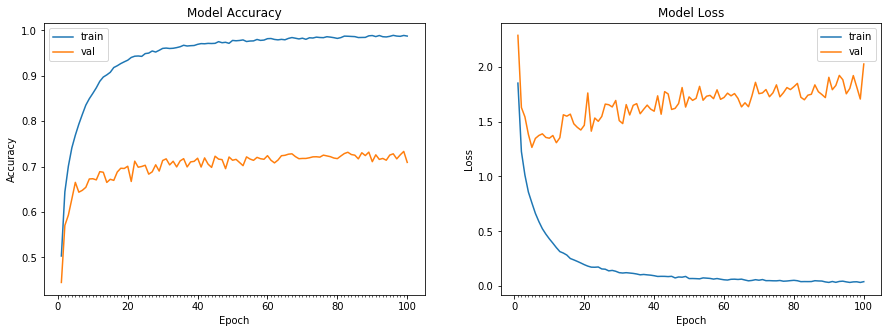

NameError: ignored

In [23]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

final_weights_path = '128_Imagenet_cifar100_weights_0_100.h5'

callbacks_list = [
    ModelCheckpoint(final_weights_path, monitor='val_acc', verbose = 1,save_best_only = True)
   
]

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=True,
                             # randomly shift images horizontally
                             width_shift_range=0.1,
                             # randomly shift images vertically
                             height_shift_range=0.1,
                             # set function that will be applied on each input
                             preprocessing_function=None,)

# Compile the model
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), callbacks = callbacks_list, verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

# Highest test accuracy achieved 73.33%